# 🚀 LangGraph Quickstart¶

Trong hướng dẫn này, chúng ta sẽ xây dựng một chatbot hỗ trợ trong LangGraph có thể:

- ✅ Trả lời các câu hỏi thường gặp bằng cách tìm kiếm trên web
- ✅ Duy trì trạng thái hội thoại giữa các lần gọi
- ✅ Định tuyến các truy vấn phức tạp đến con người để xem xét
- ✅ Sử dụng trạng thái tùy chỉnh để kiểm soát hành vi của nó
- ✅ Tua lại và khám phá các đường dẫn hội thoại thay thế

Chúng ta sẽ bắt đầu với một chatbot cơ bản và dần dần thêm các khả năng phức tạp hơn, giới thiệu các khái niệm chính của LangGraph trên đường đi. Hãy cùng bắt đầu! 🌟


## Setup

In [1]:
import os
import langgraph
from langchain_ollama import ChatOllama

### Part 1: Build a Basic Chatbot

Chúng ta sẽ bắt đầu bằng cách tạo một chatbot đơn giản sử dụng LangGraph. Chatbot này sẽ phản hồi trực tiếp các tin nhắn của người dùng. Mặc dù đơn giản, nó sẽ minh họa các khái niệm cốt lõi của việc xây dựng với LangGraph. Đến cuối phần này, bạn sẽ có một chatbot thô sơ.

Bắt đầu bằng cách tạo một `StateGraph`. Đối tượng `StateGraph` định nghĩa cấu trúc của chatbot của chúng ta như một "máy trạng thái" (state machine). Chúng ta sẽ thêm `nodes` để đại diện cho `llm` và các functions mà chatbot có thể gọi, và `edges` để chỉ định cách bot nên chuyển đổi giữa các functions này.


In [2]:
from typing import Annotated # được sử dụng để thêm metadata vào chú thích.
from typing_extensions import TypedDict # được sử dụng để tạo các dictionary types với các khóa và giá trị được chú thích.

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Định nghĩa một lớp State kế thừa từ TypedDict. 
# Điều này có nghĩa là State là một kiểu từ điển với các khóa và giá trị được chú thích kiểu.
class State(TypedDict):
  # messages: Đây là một khóa trong từ điển State.
  # Annotated[list, add_messages]: Điều này có nghĩa là giá trị của khóa messages là một danh sách (list).
  # add_messages: Đây là metadata được thêm vào chú thích kiểu. 
  # Nó cho biết rằng danh sách messages sẽ được sử dụng để lưu trữ các thông điệp và hàm add_messages sẽ được sử dụng để thêm các thông điệp vào danh sách.
  messages: Annotated[list, add_messages]
  
graph_builder = StateGraph(State)


Đồ thị của chúng ta giờ đây có thể xử lý hai nhiệm vụ chính:

* Mỗi **node** có thể nhận **State** hiện tại làm đầu vào và xuất ra bản cập nhật cho state đó.
* Các bản cập nhật cho **message** sẽ được thêm vào danh sách hiện có thay vì ghi đè, nhờ hàm **add\_messages** dựng sẵn được sử dụng với cú pháp **Annotated**.

> Khi định nghĩa một đồ thị, bước đầu tiên là định nghĩa **State** của nó. **State** bao gồm schema của đồ thị và các **reducer function** xử lý cập nhật state. Trong ví dụ của chúng ta, **State** là một **TypedDict** với một key: **messages**. **reducer function** **add\_messages** được sử dụng để thêm các message mới vào danh sách thay vì ghi đè. Các key không có chú thích reducer sẽ ghi đè các giá trị trước đó.


Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [3]:
llm_model_name='qwen2.5:7b'
llm = ChatOllama(model=llm_model_name, temperature=0)

def chatbot(state: State):
  return {"messages": [llm.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key `"messages"`. This is the basic pattern for all `LangGraph` node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph_builder.add_edge('chatbot', END)

Finally, we'll want to be able to run our graph. To do so, call `"compile()"` on the graph builder. This creates a `"CompiledGraph"` we can use invoke on our state.

In [6]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "`draw`" methods, like `draw_ascii` or `draw_png`. The draw methods each require additional dependencies.

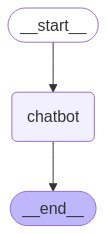

In [7]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except:
  pass

Now let's run the chatbot!

Tip: You can exit the chat loop at any time by typing "`quit`", "`exit`", or "`q`".

In [14]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
    # print(f"event values: {event.values()}")
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break

#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break

In [15]:
stream_graph_updates("Hello world")

Assistant: Hello! How can I assist you today?


### Full code

In [16]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm_model_name='qwen2.5:7b'
llm = ChatOllama(model=llm_model_name, temperature=0)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

### Part 2: 🛠️ Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

Requirements
Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the Tavily Search Engine, and set your `TAVILY_API_KEY`.

```bash
pip install -U tavily-python langchain_community
```

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
